Modified version of Google's Conditional Neural Processes, 1D regression example code to run with tensorflow 2.0.0

Tested with
- Keras                  2.3.1
- tenserflow-gpu         2.0.0
- tensorflow-probability 0.8.0

Original code available at https://github.com/deepmind/neural-processes

The descriptions and explanations from the original notebook are included where possible, but they no longer reference the same code, so they may not make perfect sense. To fully understand what's going on here read the original notebook.

Any text I have added is indicated <span style="background-color: #d5f4e6"> like this </span>, anything that is no longer true is indicated ~~like this~~. I have also tried to indicate using comments where the code is the same or similar to the original, where possible. 

---

This has not been fully tested, all I can say is it runs for what I needed it for.

 ---

Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

 [https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# Conditional Neural Processes (CNP) for 1D regression.

[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were
introduced as a continuation of
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) to extend its training regime to tasks beyond scene rendering, e.g. to
regression and classification.

In contrast to most standard neural networks, CNPs learn to approximate a
distribution over functions rather than approximating just a single function. As a result, at
test time CNPs are flexible and can approximate any function from this
distribution when provided with a handful of observations. In addition, they
learn to estimate the uncertainty of their prediction from the dataset and as
the number of observations is increased this uncertainty reduces and the
accuracy of their prediction increases.

In this notebook we describe the different parts of a CNP and apply the
resulting model to a 1D regression task where a CNP is trained on a dataset of
random functions.

Any thoughts or questions? We'd love any feedback (about this notebook or CNPs
in general) so just contact us at garnelo@google.com.

## Implementing CNPs

We start by importing the necessary dependencies. We will make use of <span style="background-color: #d5f4e6"> keras,</span> numpy,
tensorflow, <span style="background-color: #d5f4e6"> tensorflow_probability,</span> and matplotlib.

In [1]:
from keras.models import Model
from keras.layers import Dense, Input, Lambda, Concatenate

from keras import backend as K

import tensorflow as tf
import tensorflow_probability as tfp # for tf version 2.0.0, tfp version 0.8 is needed 
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


## Training data

A crucial property of CNPs is their flexibility at test time, as they can model
a whole range of functions and narrow down their prediction as we condition on
an increasing number of context observations. This behaviour is a result of the
training regime of CNPs which is reflected in our datasets.

![](https://bit.ly/2O2Lq8c)

Rather than training using observations from a single function as it is often
the case in machine learning (for example value functions in reinforcement
learning) we will use a dataset that consists of many different functions that
share some underlying characteristics. This is visualized in the figure above.
The example on the left corresponds to a classic training regime: we have a
single underlying ground truth function (eg. our value function for an agent) in
grey and at each learning iteration we are provided with a handful of examples from this
function that we have visualized in different colours for batches of different
iterations. On the right we show an example of a dataset that could be used for
training neural processes. Instead of a single function, it consists of a large number of functions of a function-class that we are interested in modeling. At each iteration we randomly choose one from the dataset and provide some observations from that function for training. For the next iteration we put that function back and
pick a new one from our dataset and use this new function to select the training
data. This type of dataset ensures that our model can't overfit to a single
function but rather learns a distribution over functions. This idea of a
hierarchical dataset also lies at the core of current meta-learning methods.
Examples of such datasets could be:

*  Functions describing the evolution of temperature over time in different cities 
of the world.
*  A dataset of functions generated by a motion capture sensor of different humans
    walking.
*   As in this particular example differents functions generated by a Gaussian process (GP)
    with a specific kernel.

We have chosen GPs for the data generation of this example because they
constitute an easy way of sampling smooth curves that share some underlying
characteristic (in this case the kernel). Other than for data generation of this
particular example neural processes do not make use of kernels or GPs as they
are implemented as neural networks.

## Data generator

In the following section we provide the code for generating our training and
testing sets using a GP to generate a dataset of functions. As we will explain
later, CNPs use two subset of points at every iteration: one to serve as the
context, and the other as targets. In practise we found that including the
context points as targets together with some additional new points helped during
training. Our data generator divides the generated data into these two groups
and provides it in the correct format.

In [2]:
# Unaltered method from the GPCurvesReader class
def gaussian_kernel(xdata, l1, sigma_f, sigma_noise=2e-2): 
    """Applies the Gaussian kernel to generate curve data.

    Args:
      xdata: Tensor with shape `[batch_size, num_total_points, x_size]` with
          the values of the x-axis data.
      l1: Tensor with shape `[batch_size, y_size, x_size]`, the scale
          parameter of the Gaussian kernel.
      sigma_f: Float tensor with shape `[batch_size, y_size]`; the magnitude
          of the std.
      sigma_noise: Float, std of the noise that we add for stability.

    Returns:
      The kernel, a float tensor with shape
      `[batch_size, y_size, num_total_points, num_total_points]`.
    """

    num_total_points = K.shape(xdata)[1]

    # Expand and take the difference
    xdata1 = K.expand_dims(xdata, axis=1)  # [B, 1, num_total_points, x_size]
    xdata2 = K.expand_dims(xdata, axis=2)  # [B, num_total_points, 1, x_size]
    diff = xdata1 - xdata2  # [B, num_total_points, num_total_points, x_size]

    # [B, y_size, num_total_points, num_total_points, x_size]
    norm = K.square(diff[:, None, :, :, :] / l1[:, :, None, None, :])

    norm = K.sum(norm, -1)  # [B, data_size, num_total_points, num_total_points]

    # [B, y_size, num_total_points, num_total_points]
    kernel = K.square(sigma_f)[:, :, None, None] * K.exp(-0.5 * norm)

    # Add some noise to the diagonal to make the cholesky work.
    kernel += (sigma_noise**2) * K.eye(num_total_points)

    return kernel

# Mostly unaltered method from the GPCurvesReader class. The inputs and outputs have been modified
def generate_curves(batch_size,
                    max_num_context,
                    x_size=1,
                    y_size=1,
                    l1_scale=0.4,
                    sigma_scale=1.0,
                    testing=False):  
    
    """Creates a regression dataset of functions sampled from a GP.

    Generated functions are `float32` with x values between -2 and 2.

    Args:
      batch_size: An integer.
      max_num_context: The max number of observations in the context.
      x_size: Integer >= 1 for length of "x values" vector.
      y_size: Integer >= 1 for length of "y values" vector.
      l1_scale: Float; typical scale for kernel distance function.
      sigma_scale: Float; typical scale for variance.
      testing: Boolean that indicates whether we are testing. If so there are
          more targets for visualization.

    Returns:
      [context pairs [x,y], target x], target y
    """
    num_context = K.random_uniform(
        shape=[], minval=3, maxval=max_num_context, dtype='int32')

    # If we are testing we want to have more targets and have them evenly
    # distributed in order to plot the function.
    if testing:
        num_target = 400
        num_total_points = num_target
        x_values = K.tile(
            K.expand_dims(tf.range(-2., 2., 1. / 100, dtype='float32'), axis=0),
            [batch_size, 1])
        x_values = K.expand_dims(x_values, axis=-1)
    # During training the number of target points and their x-positions are
    # selected at random
    else:
        num_target = K.random_uniform(
            shape=(), minval=2, maxval=max_num_context, dtype='int32')
        num_total_points = num_context + num_target
        x_values = K.random_uniform(
            [batch_size, num_total_points, x_size], -2, 2)
    
    # Set kernel parameters
    l1 = (
        K.ones(shape=[batch_size, y_size, x_size]) *
        l1_scale)
    sigma_f = K.ones(
        shape=[batch_size, y_size]) * sigma_scale

    # Pass the x_values through the Gaussian kernel
    # [batch_size, y_size, num_total_points, num_total_points]
    kernel = gaussian_kernel(x_values, l1, sigma_f)

    # Calculate Cholesky, using double precision for better stability:
    cholesky = K.cast(tf.linalg.cholesky(K.cast(kernel, 'float64')), 'float32')

    # Sample a curve
    # [batch_size, y_size, num_total_points, 1]
    y_values = tf.linalg.matmul(
        cholesky,
        K.random_normal([batch_size, y_size, num_total_points, 1]))

    # [batch_size, num_total_points, y_size]
    y_values = tf.transpose(K.squeeze(y_values, 3), [0, 2, 1])

    if testing:
        # Select the targets
        target_x = x_values
        target_y = y_values

        # Select the observations
        idx = tf.random.shuffle(tf.range(num_target))
        context_x = tf.gather(x_values, idx[:num_context], axis=1)
        context_y = tf.gather(y_values, idx[:num_context], axis=1)

    else:
        # Select the targets which will consist of the context points as well as
        # some new target points
        target_x = x_values[:, :num_target + num_context, :]
        target_y = y_values[:, :num_target + num_context, :]

        # Select the observations
        context_x = x_values[:, :num_context, :]
        context_y = y_values[:, :num_context, :]

    context_xy = tf.concat([context_x, context_y], axis=-1)
    
    return [context_xy, target_x], target_y                 

## Conditional Neural Processes

We can visualise a forward pass in a CNP as follows:

<img src="https://bit.ly/2OFb6ZK" alt="drawing" width="400"/>

As shown in the diagram, CNPs take in pairs **(x, y)<sub>i</sub>** of context
points, pass them through an **encoder** to obtain
individual representations **r<sub>i</sub>** which are combined using an **aggregator**. The resulting representation **r**
is then combined with the locations of the targets **x<sub>T</sub>** and passed
through a **decoder** that returns a mean estimate
of the **y** value at that target location together with a measure of the
uncertainty over said prediction. Implementing CNPs therefore involves coding up
the three main building blocks:

*   Encoder
*   Aggregator
*   Decoder

A more detailed description of these three parts is presented in the following
sections alongside the code.

## Encoder

The encoder **e** is shared between all the context points and consists of an
MLP with a handful of layers. For this experiment four layers are enough~~, but we
can still change the number and size of the layers when we build the graph later
on via the variable **`encoder_output_sizes`**~~. Each of the context pairs **(x,
y)<sub>i</sub>** results in an individual representation **r<sub>i</sub>** after
encoding. These representations are then combined across context points to form
a single representation **r** using the aggregator **a**.

In [3]:
input_context_xy = Input((None, 2), name="Input_layer_contxt_xy") # [num_pts, 2]
input_target_x = Input((None, 1), name="Input_layer_target_x")  # [num_pts, 1]

encoder = input_context_xy

encoder = Dense(128, activation='relu', name="Encoder_layer_0")(encoder)
encoder = Dense(128, activation='relu', name="Encoder_layer_1")(encoder)
encoder = Dense(128, activation='relu', name="Encoder_layer_2")(encoder)
representation_r_i = Dense(128, activation='linear', name="Encoder_layer_3")(encoder)


~~In this implementation we have included the aggregator **a** in the encoder as
we are only taking the mean across all points.~~ The representation **r** produced
by the aggregator contains the information about the underlying unknown function
**f** that is provided by all the context points.

In [4]:
representation_r = Lambda(lambda x: K.mean(x, axis=-2), name="Mean_layer_r")(representation_r_i)


## Decoder

Once we have obtained our representation **r** we concatenate it with each of
the targets **x<sub>t</sub>** and pass it through the decoder **d**. As with the
encoder **e**, the decoder **d** is shared between all the target points and
consists of a small MLP ~~with layer sizes defined in **`decoder_output_sizes`**~~.
The decoder outputs a mean **&mu;<sub>t</sub>** and a variance
**&sigma;<sub>t</sub>** for each of the targets **x<sub>t</sub>**. 

In this implementation we clip the variance **&sigma;<sub>t</sub>** at 0.1 to
avoid collapsing.

In [5]:
representation_r_tiled = Lambda(lambda x: K.tile(K.expand_dims(x, axis=-2), [1, K.shape(input_target_x)[-2], 1]), name="Tile_layer_r")(representation_r)

decoder_input = Concatenate(axis=-1, name="Concat_layer_r_target_x")([representation_r_tiled, input_target_x])
decoder = Dense(128, activation='relu', name="Decoder_layer_0")(decoder_input)
decoder = Dense(128, activation='relu', name="Decoder_layer_1")(decoder)
decoder = Dense(2, activation='linear', name="Decoder_layer_2")(decoder)

mu, log_sigma = Lambda(lambda x: tf.split(x, 2, axis=-1), name="Split_layer")(decoder)
sigma = Lambda(lambda x: 0.1 + 0.9 * K.softplus(x), name="Softplus_layer_sigma")(log_sigma)

To train our CNP we use the log likelihood of the ground truth value **y<sub>t</sub>** under
a Gaussian parametrized by these predicted **&mu;<sub>t</sub>** and
**&sigma;<sub>t</sub>**.

In [6]:
def log_prob(y_true, y_pred):
    mu, sigma = tf.split(y_pred, 2, axis=-1)

    dist = tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    log_p = dist.log_prob(y_true)
    
    loss = -K.mean(log_p)
    
    return loss

## Model

Now that the main building blocks (encoder, aggregator and decoder <span style="background-color: #d5f4e6">, loss function </span>) of the CNP
are defined we can put everything together into one model. ~~Fundamentally this
model only needs to include two main methods: 1. A method that returns the log
likelihood of the targets' ground truth values under the predicted
distribution.This method will be called during training as our loss function. 2.
Another method that returns the predicted mean and variance at the target
locations in order to evaluate or query the CNP at test time. This second method
needs to be defined separately as, unlike the method above, it should not depend
on the ground truth target values.~~

<span style="background-color: #d5f4e6"> Combine everything into one model. **&mu;** and **&sigma;** are concatenated together as it is easier to handle the output as a single object </span>

In [7]:
output = Concatenate(axis=-1, name="Concat_layer_mu_sigma")([mu, sigma])

model = Model([input_context_xy, input_target_x], output)

model.compile(loss=log_prob, optimizer='adam')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer_contxt_xy (InputLay (None, None, 2)      0                                            
__________________________________________________________________________________________________
Encoder_layer_0 (Dense)         (None, None, 128)    384         Input_layer_contxt_xy[0][0]      
__________________________________________________________________________________________________
Encoder_layer_1 (Dense)         (None, None, 128)    16512       Encoder_layer_0[0][0]            
__________________________________________________________________________________________________
Encoder_layer_2 (Dense)         (None, None, 128)    16512       Encoder_layer_1[0][0]            
____________________________________________________________________________________________

## Plotting function
We define a helper function for plotting the intermediate predictions
~~every `PLOT_AFTER` iterations~~. The ground truth curve will be shown as a black
dotted line and the context points from this curve that are fed into the model
as black dots. The model's predicted mean and variance is shown in blue for a
range of target points in the interval [-2, 2].

In [8]:
# Mostly unaltered function from original code
def plot_functions(target_x, target_y, context_x, context_y, pred_y, var):
    """Plots the predicted mean and variance and the context points.

    Args: 
    target_x: An array of shape batchsize x number_targets x 1 that contains the
        x values of the target points.
    target_y: An array of shape batchsize x number_targets x 1 that contains the
        y values of the target points.
    context_x: An array of shape batchsize x number_context x 1 that contains 
        the x values of the context points.
    context_y: An array of shape batchsize x number_context x 1 that contains 
        the y values of the context points.
    pred_y: An array of shape batchsize x number_targets x 1  that contains the
        predicted means of the y values at the target points in target_x.
    pred_y: An array of shape batchsize x number_targets x 1  that contains the
        predicted variance of the y values at the target points in target_x.
    """
    # Plot everything
    plt.plot(target_x, pred_y, 'b', linewidth=2)
    plt.plot(target_x, target_y, 'k:', linewidth=2)
    plt.plot(context_x, context_y, 'ko', markersize=10)
    plt.fill_between(
      target_x,
      pred_y - var,
      pred_y + var,
      alpha=0.2,
      facecolor='#65c9f7',
      interpolate=True)

    # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid('off')
#     ax = plt.gca()
#     ax.set_axis_bgcolor('white')
    plt.show()

## Running Conditional Neural Processes

Now that we have defined the dataset as well as our model and its components we
can start building everything into the graph. Before we get started we need to
set some variables:

*   ~~**`TRAINING_ITERATIONS`** - a scalar that describes the number of iterations
    for training. At each iteration we will sample a new batch of functions from
    the GP, pick some of the points on the curves as our context points **(x,
    y)<sub>C</sub>** and some points as our target points **(x,
    y)<sub>T</sub>**. We will predict the mean and variance at the target points
    given the context and use the log likelihood of the ground truth targets as
    our loss to update the model.~~
*   **`MAX_CONTEXT_POINTS`** - a scalar that sets the maximum number of contest
    points used during training. The number of context points will then be a
    value between 3 and `MAX_CONTEXT_POINTS` that is sampled at random for every
    iteration.
*   ~~**`PLOT_AFTER`** - a scalar that regulates how often we plot the
    intermediate results.~~

<span style="background-color: #d5f4e6"> I have tried to replicate the original functionality of the code, by plotting intermediate results. <br> 
Here the training is repeated **`repeats`** times and each repeat a sample graph is plotted. <br>
**`epochs`** is the number of epochs performed every repeat and at the end of each epoch the value of the loss and val_loss is recorded. <br>
**`steps_per_epoch`** and **`validation_steps`** are the number of steps performed every epoch. The recorded losses are calculated from the loss of these steps </span>

In [9]:
MAX_CONTEXT_POINTS = 10

repeats = 10
epochs = 10
steps_per_epoch = 2e2
validation_steps = 10
batch_size = 64

We add the dataset reader to the graph for both the training and the testing
set. As mentioned above for this experiment the dataset consists of functions
that are sampled anew from a GP at each iteration. The main difference between
train and test in this case is that the test set contains more targets so that
we can plot the entire curve, whereas the training set only contains a few
target points to predict.

<span style="background-color: #d5f4e6"> This implementation uses the following code, to call the functions at the beginning of the notebook in order to generate the data sets </span>

In [10]:
def generate(batch_size, max_num_context, testing):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        inputs, targets = generate_curves(batch_size, max_num_context, testing=testing)
        yield (inputs, targets)

We are ready to train the model! During training we will plot some intermediate
predictions to visualize how the model evolves.

Every ~~`PLOT_AFTER` iterations~~ <span style="background-color: #d5f4e6"> epoch </span> we print out the loss, which corresponds to the
negative log probability of the ground truth targets under the predicted
distribution. As the model is trained this value should decrease.

In addition we are going to plot the predictions of our model alongside the
ground truth curve and the context points that the CNP is provided at that
iteration.

<span style="background-color: #d5f4e6"> In addition **`hist`** is defined to store the losses recorded during training so they can be printed out at the end</span>

Training model
*****************************
Repeat 1
Epoch 1/10
200/200 [==============================] - 2s 9ms/step - loss: 1.1193 - val_loss: 2.3332
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.9785 - val_loss: 0.9465
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.9275 - val_loss: 0.8996
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.8599 - val_loss: 1.2134
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.7992 - val_loss: 0.7218
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.7822 - val_loss: 0.5236
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.7147 - val_loss: 0.7068
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.7130 - val_loss: 1.6154
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.6890 - val_loss: 0.6016
Epoch 10/10
200/200 [=========================

/homes/crf36/testenv/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


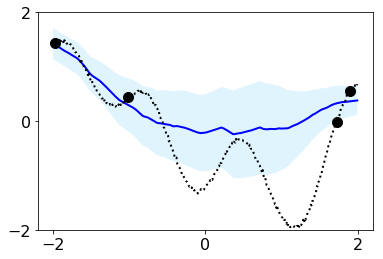

*****************************
Repeat 2
Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.6381 - val_loss: 0.9991
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.6002 - val_loss: 0.8017
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.5889 - val_loss: 1.6840
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.5490 - val_loss: 0.6508
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.5370 - val_loss: 2.6151
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.5224 - val_loss: 1.0657
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.5056 - val_loss: 0.9918
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.4991 - val_loss: 0.7675
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.4680 - val_loss: 0.8156
Epoch 10/10
200/200 [==============================] - 2s 8ms

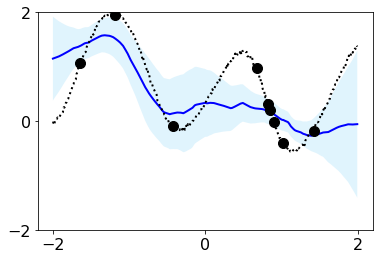

*****************************
Repeat 3
Epoch 1/10
200/200 [==============================] - 2s 9ms/step - loss: 0.4791 - val_loss: 0.6934
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.4297 - val_loss: 2.3762
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.4358 - val_loss: 1.2883
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.4249 - val_loss: 0.5209
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.3977 - val_loss: 0.4619
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.4014 - val_loss: 0.4702
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.3987 - val_loss: 0.4151
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.3869 - val_loss: 1.0922
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.3844 - val_loss: 1.1811
Epoch 10/10
200/200 [==============================] - 2s 8ms

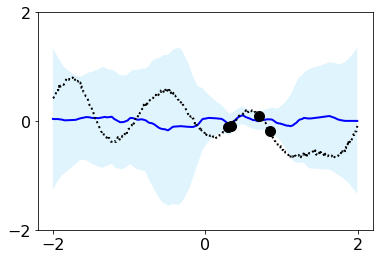

*****************************
Repeat 4
Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.3569 - val_loss: 0.9582
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.3471 - val_loss: 1.8617
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.3399 - val_loss: 0.3393
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.3391 - val_loss: 0.4939
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.3181 - val_loss: 0.8040
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.3363 - val_loss: 0.0577
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2995 - val_loss: 0.4912
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2910 - val_loss: 0.6530
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.3178 - val_loss: 0.4620
Epoch 10/10
200/200 [==============================] - 2s 8ms

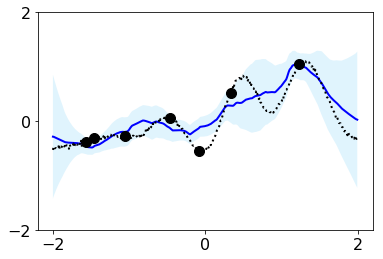

*****************************
Repeat 5
Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2984 - val_loss: 0.4991
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2783 - val_loss: 1.3435
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2858 - val_loss: 0.9189
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2475 - val_loss: 1.1243
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2785 - val_loss: 0.2401
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2789 - val_loss: 0.9925
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2597 - val_loss: 0.6897
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2341 - val_loss: 0.6623
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2382 - val_loss: 0.3377
Epoch 10/10
200/200 [==============================] - 2s 9ms

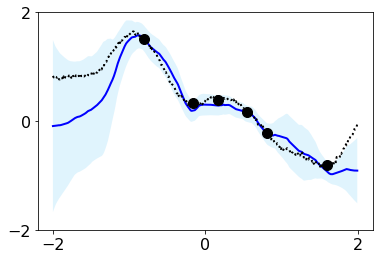

*****************************
Repeat 6
Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2444 - val_loss: 0.8247
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2653 - val_loss: 0.1100
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2302 - val_loss: 0.4907
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2207 - val_loss: 0.4964
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2216 - val_loss: 0.4093
Epoch 6/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2090 - val_loss: 1.5522
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2294 - val_loss: 0.5324
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2159 - val_loss: 1.6488
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1974 - val_loss: 0.6074
Epoch 10/10
200/200 [==============================] - 2s 9m

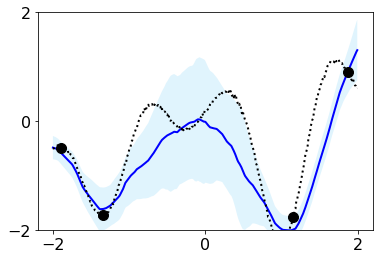

*****************************
Repeat 7
Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2057 - val_loss: 0.9089
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1801 - val_loss: 0.7484
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1850 - val_loss: 0.8670
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2089 - val_loss: 0.3615
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1610 - val_loss: 0.4982
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1998 - val_loss: 0.4291
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1743 - val_loss: 0.5783
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1742 - val_loss: 0.5564
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1472 - val_loss: 0.2094
Epoch 10/10
200/200 [==============================] - 2s 8ms

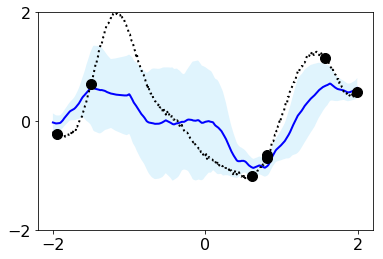

*****************************
Repeat 8
Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1696 - val_loss: 1.1099
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1720 - val_loss: 0.7449
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1776 - val_loss: 0.4815
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1468 - val_loss: 0.2639
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1808 - val_loss: 1.5837
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1588 - val_loss: 0.5252
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1488 - val_loss: 1.0405
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1480 - val_loss: 0.3774
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1430 - val_loss: 0.6695
Epoch 10/10
200/200 [==============================] - 2s 8ms

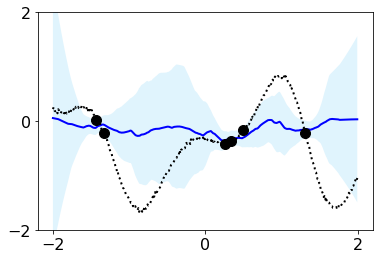

*****************************
Repeat 9
Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1683 - val_loss: 1.0240
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1245 - val_loss: 0.5920
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1268 - val_loss: 1.7574
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1290 - val_loss: 0.9831
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1429 - val_loss: 0.4768
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1300 - val_loss: 0.0146
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1243 - val_loss: 0.2312
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1449 - val_loss: 0.6282
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1301 - val_loss: 0.0201
Epoch 10/10
200/200 [==============================] - 2s 8ms

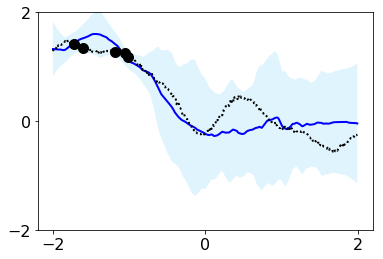

*****************************
Repeat 10
Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0982 - val_loss: 0.5385
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1163 - val_loss: 0.1069
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1480 - val_loss: 0.6324
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1011 - val_loss: 0.1695
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1294 - val_loss: 0.1676
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1044 - val_loss: 1.1091
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1172 - val_loss: 0.7458
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1209 - val_loss: 3.2015
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1175 - val_loss: 0.9720
Epoch 10/10
200/200 [==============================] - 2s 8m

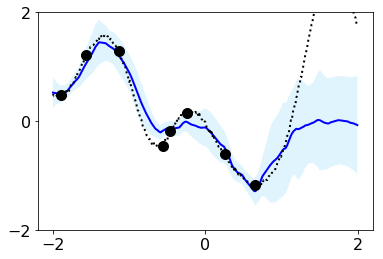

In [11]:
print('Training model')

hist = np.zeros([2, repeats*epochs], dtype='float32')

for i in range(repeats):
    print("*****************************")
    print("Repeat %i" % (i+1))
    history = model.fit_generator(
                    generate(batch_size, MAX_CONTEXT_POINTS, testing=False),
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=generate(1, MAX_CONTEXT_POINTS, testing=True),
                    validation_steps=validation_steps)
    
    hist[0,i*epochs:(i+1)*epochs] = history.history['loss']
    hist[1,i*epochs:(i+1)*epochs] = history.history['val_loss']
    
    inputs, target_y = generate_curves(1, MAX_CONTEXT_POINTS, testing=True)
    pred = model.predict(inputs, steps=1)

    target_x = K.squeeze(inputs[1][0], axis=1)
    target_y = K.squeeze(target_y[0], axis=1)
    context_x = inputs[0][0, :, 0]
    context_y = inputs[0][0, :, 1]
    pred_y = pred[0, :, 0]
    var = pred[0, :, 1]

    plot_functions(target_x, target_y, context_x, context_y, pred_y, var)

<span style="background-color: #d5f4e6"> Plot the recorded loss values </span>

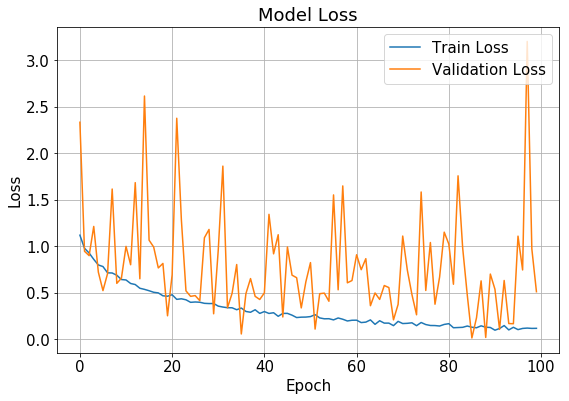

In [12]:
plt.figure(figsize=(9,6))
plt.plot(hist[0])
plt.plot(hist[1])
plt.title('Model Loss', fontsize=18)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid()
plt.show()